In [5]:
#Load in data from matlab mat file and put it in a pandas array
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
data = sio.loadmat('c_yperformance.mat')
x_values = sio.loadmat('xaxis.mat')
performance = data['C_YPerformance']
x_axis_array = x_values['C_XaxisRSIplot']
#Remove duplicate rows from this array
x_axis = x_axis_array[1]

In [6]:
#Transform probabilities back into counts for "number of successes". This is not my data, and I don't have access to the original source so I am estimating some of it (only for the hypothesis figure)
#In this dataset, trials types occured at different rates. The first and last column (RSI 1 and RSI 0) occured most often. The middle columns each had 80 trials out of a total 1500; I am estimating 500 each for the 1 and 0 positions. 
performance[:,0] = performance[:,0]*500
performance[:,1:6] = performance[:,1:6]*80
performance[:,6] = performance [:,6]*500

performance_fall = performance[0:7,:]
performance_spring = performance[8:11,:]

In [7]:
fall_performance_sum = np.sum(performance_fall,0)
spring_performance_sum = np.sum(performance_spring,0)
fall_total_trials = [3500,560,560,560,560,560,3500]
spring_total_trials = [1500,240,240,240,240,240,1500]

In [8]:
spring_performance_sum

#add comment test

array([1432.58774308,  135.66137566,  102.16296296,   32.72141707,
         11.87724868,    5.71428571,   17.55892809])

In [9]:
fall_performance_sum

array([3357.24220386,  243.52899527,  125.24427223,   93.16199929,
         37.14309347,   44.36465018,   48.81218789])

In [10]:
import astropy.stats as aps

In [11]:
spring_CIs = aps.binom_conf_interval(spring_performance_sum,spring_total_trials,.95,'wilson')
fall_CIs = aps.binom_conf_interval(fall_performance_sum,fall_total_trials,.95,'wilson')

In [12]:
fall_CIs

array([[0.95206549, 0.39346767, 0.19067821, 0.13754516, 0.048312  ,
        0.05904861, 0.01035978],
       [0.96521345, 0.47528977, 0.25952185, 0.19914781, 0.08974357,
        0.10383664, 0.01813507]])

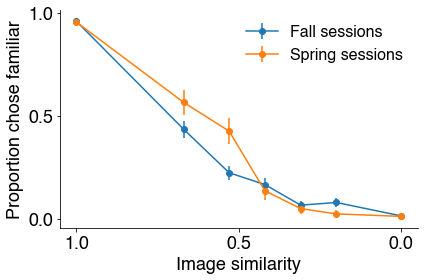

In [48]:
hfont = {'fontname':'Helvetica'}
font = fm.FontProperties(family='Helvetica',
                                   weight='normal',
                                   style='normal', size=16)

ax = plt.subplot(111)
ax.errorbar(x_axis,fall_performance_sum/fall_total_trials,(fall_CIs[0]-fall_CIs[1])/2,marker='o')
ax.errorbar(x_axis,spring_performance_sum/spring_total_trials,(spring_CIs[0]-spring_CIs[1])/2,marker='o')
#plt.fill_between(x_axis,fall_CIs[0],fall_CIs[1],alpha=.2)
#%plt.fill_between(x_axis,spring_CIs[0],spring_CIs[1],alpha=.2)

plt.legend(['Fall sessions','Spring sessions'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('hypothesis_plot.pdf')


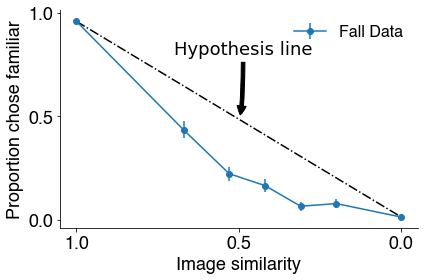

In [51]:
fall_performance = fall_performance_sum/fall_total_trials
fallplot = plt.subplot(111)
fallplot.errorbar(x_axis,fall_performance_sum/fall_total_trials,(fall_CIs[0]-fall_CIs[1])/2,marker='o')
fallplot.plot([x_axis[0],x_axis[6]],[fall_performance[0],fall_performance[6]],linestyle='-.',color='k',label='_nolegend_')
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
fallplot.spines['right'].set_visible(False)
fallplot.spines['top'].set_visible(False)
fallplot.annotate("Hypothesis line",
            xy=(0.5, 0.5), xycoords='data',
            fontsize=18,
            xytext=(.7, 0.8), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="angle3",
                            facecolor='k'),
            )
plt.legend(['Fall Data'],prop=font,frameon=False)
plt.tight_layout()




In [25]:
fall_performance = fall_performance_sum/fall_total_trials

In [94]:
#Defines function that "makes prediction" based on a line drawn between hits and correct rejections (i.e. if the system was fully linear). Takes in the hit and CR values and returns a point on that line for a specified similarity value
def make_prediction(hits,crs,similarity):
    slope = (hits-crs)/(1-0) #y1-y2 / x1-x2. Written out for clarity.
    intercept =  crs #b = y-intercept = (x1*y2 - x2*y1)/(x1-x2)
    y = ((slope * similarity) + crs)
    return y
#y=make_prediction(fall_performance[0],fall_performance[6],x_axis[6])


0.013946339397740972

In [99]:
#Binomial exact test for question "is fall different from benchmark line? Makes array with p values for each point on the line
pvalues_fall=[]
import scipy.stats as stats
for i in range(0,7):
    pvalues_fall.append(stats.binom_test(fall_performance_sum[i],fall_total_trials[i],make_prediction(fall_performance[0],fall_performance[6],x_axis[i])))
pvalues_fall

[0.9659127408084252,
 1.1169839867571827e-24,
 2.3907030404638906e-45,
 1.3310734274299197e-35,
 9.293685900761006e-45,
 8.798695745496838e-16,
 1.0]

In [107]:
#There is no test implemented in SciPy that tests between two binomial quantities. Crazy. Here I implement the following test from the engineering statistics handbook that approximates binomial distributions as normal for large numbers (which we have here): https://www.itl.nist.gov/div898/handbook/prc/section3/prc33.htm

def two_binomials(a_success,a_trials,b_success,b_trials):
    p_a = a_success/a_trials
    p_b = b_success/b_trials
    phat = (a_success + b_success)/(a_trials+b_trials)
    z = (p_a - p_b)/((phat * (1-phat)) * ((1/(a_trials)) + (1/(b_trials))))**.5
    #Find p value
    pvalue = stats.norm.sf(abs(z))
    return pvalue

spring_fall_pvalues = []
for i in range(0,7):
    spring_fall_pvalues.append(two_binomials(fall_performance_sum[i],fall_total_trials[i],spring_performance_sum[i],spring_total_trials[i]))
spring_fall_pvalues

[0.25120008955224427,
 0.0003565601784406592,
 3.2105983593256234e-09,
 0.14261958282447695,
 0.18141002469933487,
 0.001513522577106292,
 0.2629328778947668]

Text(0.8, 0.1, 'Hypothesis line')

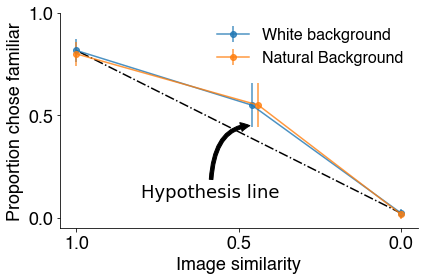

In [138]:
wbx_x = np.array([0,.46,1])
wbx_x_jittered = np.array([0,.44,1])

nb_nb_success = np.array([4,44,147])
nb_wb_success = np.array([3,44,144])


nb_total_trials = np.array([180,80,180])
wb_total_perf = nb_nb_success/nb_total_trials

nb_nb_CIs = aps.binom_conf_interval(nb_nb_success,nb_total_trials,.95,'wilson')
nb_wb_CIs = aps.binom_conf_interval(nb_wb_success,nb_total_trials,.95,'wilson')

ax2 = plt.subplot(111)
ax2.errorbar(wbx_x,nb_nb_success/nb_total_trials,(nb_nb_CIs[0]-nb_nb_CIs[1])/2,marker='o',alpha=.8)
ax2.errorbar(wbx_x_jittered,nb_wb_success/nb_total_trials,(nb_wb_CIs[0]-nb_wb_CIs[1])/2,marker='o',alpha=.8)
ax2.plot([wbx_x[0],wbx_x[2]],[wb_total_perf[0],wb_total_perf[2]],linestyle='-.',color='k',label='_nolegend_')

#plt.fill_between(wbx_x,nb_nb_CIs[0],nb_nb_CIs[1],alpha=.2)
#plt.fill_between(wbx_x_jittered,nb_wb_CIs[0],nb_wb_CIs[1],alpha=.2)
plt.legend(['White background','Natural Background'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('results_plot.pdf')

ax2.annotate("Hypothesis line",
                  xy=(0.46, 0.45), xycoords='data',
                  fontsize=18,
                  xytext=(.8, 0.1), textcoords='data',
                  arrowprops=dict(arrowstyle="simple",
                                  connectionstyle="angle3",
                                  facecolor='k'),
                  )



In [132]:
#Fisher's exact test for if WN And NB are significantly different. The mean's aren't even different lol but for completelness sake should be done

#Make contingency table where columns are WB and NB, rows are "success" and "miss"
cont_table = [[44,44],[36,36]]
#Fisher exact test for if...these two identical quantities...are different lol
stats.fisher_exact(cont_table,'two-sided')

(0.4074074074074074, 0.012569446408829277)

In [142]:
#Are the lure pairs significantly different from the linear hypothesis?
wbs_null_test = (stats.binom_test(44,80,make_prediction(wb_total_perf[2],wb_total_perf[0],.46)))
wbs_null_test

0.003867119794459111

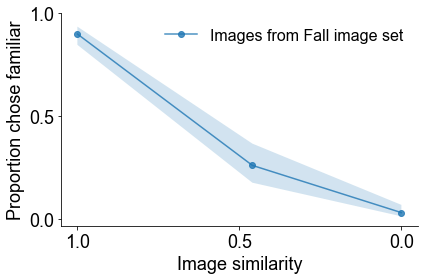

In [98]:
wbx_x = np.array([0,.46,1])
wbx_x_jittered = np.array([0,.42,1])

nb_nb_success = np.array([6,21,162])

nb_total_trials = np.array([180,80,180])

nb_nb_CIs = aps.binom_conf_interval(nb_nb_success,nb_total_trials,.95,'wilson')
nb_wb_CIs = aps.binom_conf_interval(nb_wb_success,nb_total_trials,.95,'wilson')

ax3 = plt.subplot(111)
ax3.plot(wbx_x,nb_nb_success/nb_total_trials,marker='o',alpha=.8)
plt.fill_between(wbx_x,nb_nb_CIs[0],nb_nb_CIs[1],alpha=.2)
plt.legend(['Images from Fall image set'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('alzheimers_plot.pdf')

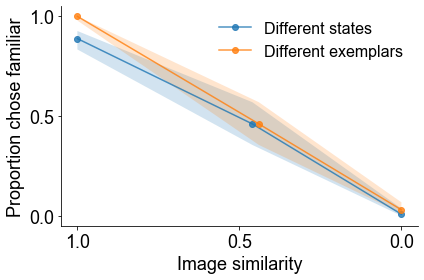

In [107]:
wbx_x = np.array([0,.46,1])
wbx_x_jittered = np.array([0,.44,1])

nb_nb_success = np.array([2,37,160])
nb_wb_success = np.array([6,37,180])

nb_total_trials = np.array([180,80,180])

nb_nb_CIs = aps.binom_conf_interval(nb_nb_success,nb_total_trials,.95,'wilson')
nb_wb_CIs = aps.binom_conf_interval(nb_wb_success,nb_total_trials,.95,'wilson')

ax2 = plt.subplot(111)
ax2.plot(wbx_x,nb_nb_success/nb_total_trials,marker='o',alpha=.8)
ax2.plot(wbx_x_jittered,nb_wb_success/nb_total_trials,marker='o',alpha=.8)
plt.fill_between(wbx_x,nb_nb_CIs[0],nb_nb_CIs[1],alpha=.2)
plt.fill_between(wbx_x_jittered,nb_wb_CIs[0],nb_wb_CIs[1],alpha=.2)
plt.legend(['Different states','Different exemplars'],prop=font,frameon=False)
plt.gca().invert_xaxis()
plt.xlabel("Image similarity",**hfont,size=18)
plt.ylabel("Proportion chose familiar",**hfont,size=18)
plt.xticks([1,.5,0],**hfont,size=18)
plt.yticks([0,.5,1],**hfont,size=18)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('results_plot_states.pdf')
